# Q5's Teamwork

- Aleksandar Mona Macko Puhek
- Chuying He
- Ioannis Lavdas
- Lorena Mendez
- Pantelis Fragkos

# Introduction

Multipartite entangled GHZ states were first proposed in 1989 <sup>[1]</sup> and experimentally confirmed in 1998 <sup>[2]</sup>. Since then, a number of qubits in entangled GHZ states and a number of quantum computer architectures realizing them has grown <sup>[3]</sup>. Quantum circuits realizing these states consists of parts generating these states and of parts verifying these states. Recently, an entangled GHZ state with 18 qubits was realized on an IBM quantum computer with fidelity of around one half <sup>[4]</sup>.  

[1] arXiv:0712.0921

[2] J.-W. Pan and A. Zeilinger, Phys. Rev. A. 57:2208 (1998)

[3] C. Song et al, Phys. Rev. Lett. 119:180511 (2017), T. Monz et al, Phys. Rev. Lett. 106:130506 (2011), X.-L. Wang et al, Phys. Rev. Lett. 120:260502 (2018)

[4] arXiv:1905..05720v1.

# Idea

In this notebook, we implement two ways of generating a GHZ state tested on a quantum emulator based on an IBM quantum computer. Verification is performed with a multi-qubit metric tested previously on an IBM quantum computer which represents current state-of-the-art according to our knowledge <sup>[Ref. 4 in Introduction]</sup>.  

We use emulators based on the following machine: ibm-lagos (7-qubits).

# Solution

## "Naive" GHZ State Generation

<!-- ![graph_naive.png](attachment:graph_naive.png) -->
 <img src="./assets/graph_naive.png" alt="app-screen" width="300" />

In [5]:
from qiskit import QuantumCircuit, execute, Aer

def generate_naive_ghz_state(qubit_amount):
    """Prepare a GHZ state on n qubits."""
    # Initialize a quantum circuit with n qubits
    qc = QuantumCircuit(qubit_amount)

    # Apply a Hadamard gate to the first qubit
    qc.h(0)

    # Apply a CNOT gate between the first qubit and each of the other qubits
    for i in range(1, qubit_amount):
        qc.cx(0, i)

    qc.measure_all()

    return qc

## Generalized GHZ State Generation

A GHZ generation different from the naive one used in [4] is proposed here. It is based on a dynamic 

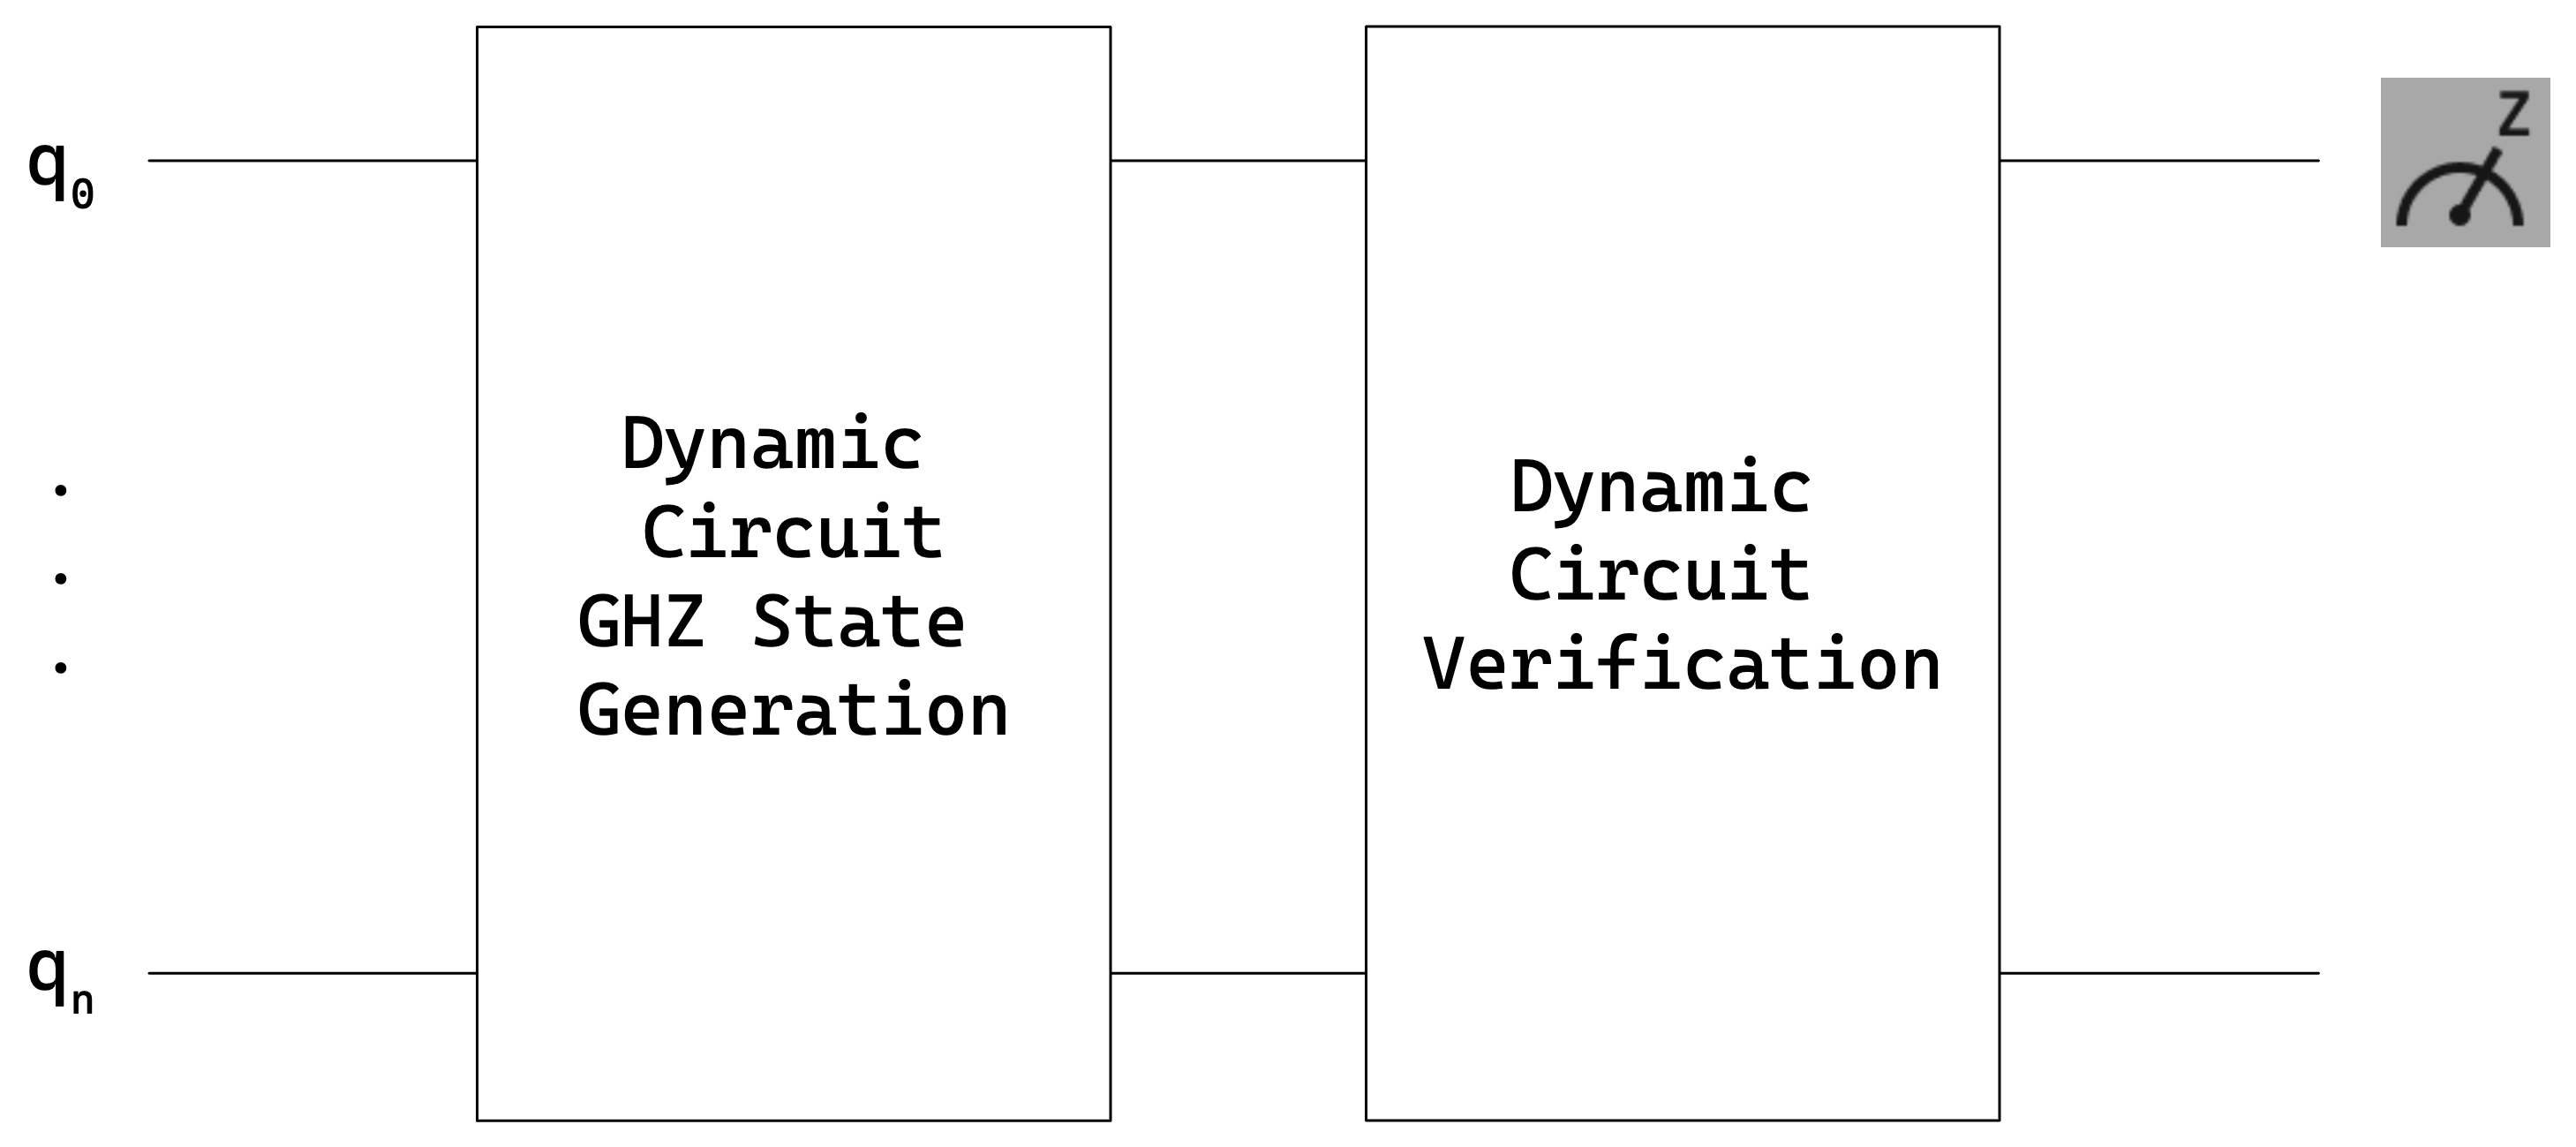

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

def generate_generalized_ghz_state(qubit_amount):
    """_summary_

    Args:
        qubit_amount (_type_): amount of the qubits

    Returns:
        _type_: QuantumCircuit
    """
    total_qubit_amount = 2*qubit_amount-1
    
    qr = QuantumRegister(total_qubit_amount)
    cr = ClassicalRegister(total_qubit_amount)
    qc = QuantumCircuit(qr, cr)
    
    even_qubit_list = list(range(0,2*qubit_amount,2))
    odd_qubit_list = list(range(1,2*qubit_amount-1,2))
        
    qc.h(even_qubit_list)
    qc.cx(even_qubit_list[:-1], odd_qubit_list)
    qc.cx(even_qubit_list[1:], odd_qubit_list)
    
    qc.measure(qr[1::2], cr[1::2])
    
    # Measure and perform conditional operations
    n = total_qubit_amount
    
    for i in range(1, n, 2):
        with qc.if_test((cr[i], 1)):
            qc.x(list(range(i+1, n, 2)))
    
    qc.barrier()
    
    qc.measure(qr[::2], cr[::2])
    
    return qc

# Results

## Plotting

In [7]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit.providers.fake_provider import FakeSherbrooke

def plot_noise(qc):
    # Fake Provider Backends
    device_backend = FakeSherbrooke()

    sim_sherbrooke = AerSimulator.from_backend(device_backend)

    # Transpile the circuit for the noisy basis gates
    t_qc = transpile(qc, sim_sherbrooke)

    # Execute noisy simulation and get counts
    result_noise = sim_sherbrooke.run(t_qc).result()
    counts_noise = result_noise.get_counts(0)
    return counts_noise    

In [8]:
def cluster_counts(counts_noise, qubit_amount):
    new_counts = {}
    for el in counts_noise: 
        even_list = [el[i] for i in range(0, qubit_amount*2-1, 2)]
        try:
            new_counts["".join(even_list)] = new_counts["".join(even_list)] + counts_noise[el]
        except:
            new_counts["".join(even_list)] = counts_noise[el]
    return new_counts

In [9]:
# INPUT VARIABLE
qubit_amount=5

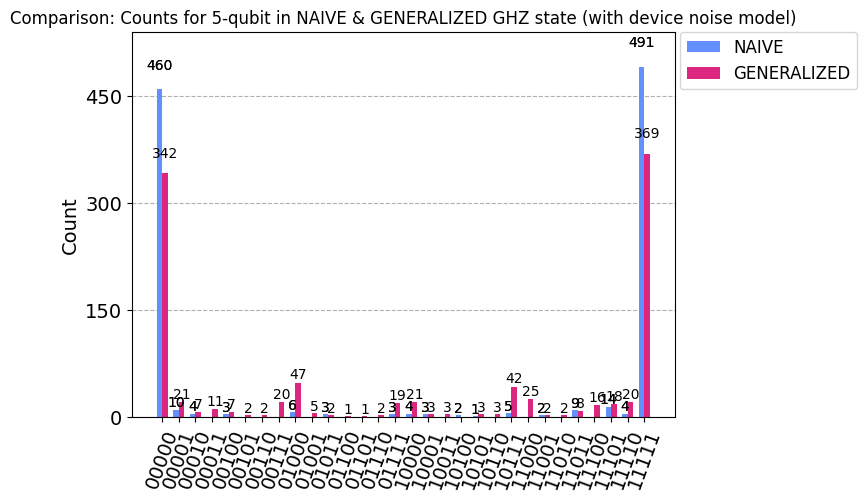

In [10]:
# PLOTTING NAIVE & GENERALIZED GHZ STATE
## NAIVE
naive_qc = generate_naive_ghz_state(qubit_amount)
naive_counts_noise = plot_noise(naive_qc)

## GENERALIZED
generalized_qc = generate_generalized_ghz_state(qubit_amount)
generalized_counts_noise=plot_noise(generalized_qc)
clusterd_generalized_counts_noise = cluster_counts(generalized_counts_noise, qubit_amount)

## PLOTTING
legend = ["NAIVE", "GENERALIZED"]
plot_histogram([naive_counts_noise,clusterd_generalized_counts_noise],
               legend=legend,
               title=f"Comparison: Counts for {qubit_amount}-qubit in NAIVE & GENERALIZED GHZ state (with device noise model)")

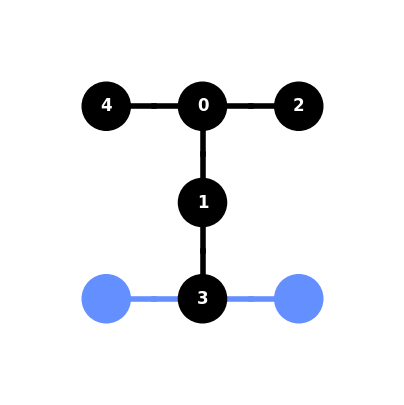

In [36]:
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeTorontoV2, FakeLagosV2

# Fake Provider Backends
device_backend = FakeLagosV2()

sim_sherbrooke = AerSimulator.from_backend(device_backend)

# Transpile the circuit for the noisy basis gates
t_qc = transpile(naive_qc, sim_sherbrooke)

plot_circuit_layout(t_qc, device_backend)

In [42]:
from qiskit.providers.models import BackendConfiguration
# BackendConfiguration(device_backend, coupling_map)
print(device_backend.coupling_map)

print(device_backend.num_qubits)

[[5, 4], [4, 5], [3, 1], [1, 3], [5, 6], [6, 5], [5, 3], [3, 5], [2, 1], [1, 2], [0, 1], [1, 0]]
7
